In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
# bid = map(lambda x: (x['price'], x['size']), sorted(filter(lambda x: x['side'] == 'Buy', market_depth), key=lambda x: -x['price']))
# ask = map(lambda x: (x['price'], x['size']), sorted(filter(lambda x: x['side'] == 'Sell', market_depth), key=lambda x: x['price']))

# bid = pd.DataFrame(bid, columns=['price', 'size'])
# bid = bid[bid['size'].cumsum() <= 50M]

# ask = pd.DataFrame(ask, columns=['price', 'size'])
# ask = ask[ask['size'].cumsum() <= 50M]

# weighted_price = ((bid['price'] * bid['size']).sum() + (ask['price'] * ask['size']).sum()) / (bid['size'].sum() + ask['size'].sum())

In [3]:
df = pd.read_pickle('data_wp')

In [4]:
df

,open,high,low,close,50M,60M,70M,80M,90M,100M,110M,120M,130M,140M,150M
timestamp,,,,,,,,,,,,,,,
2019-04-01 00:00:00,4091.0,4091.0,4091.0,4091.0,4085.571400,4085.130774,4087.437362,4084.554931,4084.907248,4084.204241,4084.122591,4084.557309,4085.346957,4086.800757,4090.625193
2019-04-01 00:00:05,4091.0,4091.0,4091.0,4091.0,4085.399523,4084.791366,4087.413743,4084.522832,4084.187821,4084.176147,4084.155550,4084.534677,4085.222487,4087.068056,4090.805397
2019-04-01 00:00:10,4091.0,4091.5,4089.0,4091.5,4082.529929,4083.166928,4083.417778,4083.459346,4082.776234,4082.616253,4082.332862,4082.124100,4083.247482,4084.769454,4087.996800
2019-04-01 00:00:15,4091.0,4091.0,4090.0,4090.0,4082.530385,4083.167300,4083.418102,4083.459627,4082.776490,4082.616484,4082.339690,4082.139391,4083.247656,4084.769610,4087.996931
2019-04-01 00:00:20,4090.0,4090.0,4089.5,4089.5,4082.625409,4083.132137,4083.597657,4083.434033,4082.852947,4082.594677,4082.461301,4082.380484,4083.224374,4085.025355,4087.980490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 23:59:40,56982.5,56984.0,56982.0,56984.0,56933.358259,56905.529823,56891.109569,56884.600594,56846.962940,56787.134872,56684.219557,56614.056547,56557.341366,56528.962572,56501.849834
2021-03-16 23:59:45,56984.5,57000.5,56984.5,56999.5,56927.318710,56900.524021,56897.526770,56887.541229,56853.438592,56797.369961,56699.554637,56617.588829,56578.474896,56534.045808,56505.978890
2021-03-16 23:59:50,57000.0,57003.5,57000.0,57003.5,56933.382341,56902.808522,56893.980914,56897.732631,56862.060212,56761.454735,56680.456887,56626.673234,56556.217750,56519.648433,56487.811176


In [5]:
@njit
def predict_njit(start_equity, threshold, max_position, X, imbalance):
    tick_size = 0.5
    running_qty = 0
    static_equity = start_equity
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    for row in X:
        if new_bid > row[low]:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * -0.00025    
        if new_ask < row[high]:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * -0.00025    
        equity.append(static_equity * row[close] - running_qty - fee * row[close])
        running_qty_.append(running_qty)
        running_qty_hedged = running_qty + equity[-1]
        ind = row[imbalance] - row[close]
        if ind > threshold and running_qty_hedged < max_position:
            new_bid = row[close] - tick_size
        else:
            new_bid = np.nan
        if ind < -threshold and running_qty_hedged > -max_position:
            new_ask = row[close] + tick_size
        else:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, equity=None, max_position=None, threshold=None, imbalance=None):
        self.equity = equity
        self.max_position = max_position
        self.threshold = threshold
        self.imbalance = imbalance
        
    def set_params(self, threshold, imbalance):
        self.threshold = threshold
        self.imbalance = imbalance
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'threshold': self.threshold, 'imbalance': self.imbalance }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.equity, self.threshold, self.max_position, X, self.imbalance)
        return equity, running_qty
    
    def score(self, X):
        equity, running_qty = self.predict(X)
        returns = pd.Series(equity).pct_change().fillna(0)
        return np.divide(returns.mean(), returns.std())

In [6]:
train = df[(df.index >= '2019-7-1') & (df.index < '2020-1-1')]
valid = df[(df.index >= '2020-1-1') & (df.index < '2021-1-8')]

In [9]:
param_dist = { 'threshold': stats.uniform(0, 100), 'imbalance': np.arange(4, 11) }
search = RandomizedSearchCV(Backtest(1, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   45.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  3.9min finished


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 3179517, 3179518, 3179519]),
                        array([      0,       1,       2, ..., 3179517, 3179518, 3179519]))],
                   estimator=<__main__.Backtest object at 0x7f8c295944d0>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'imbalance': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'threshold': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8c29594610>},
                   verbose=1)

In [10]:
# v2.1 params
# search.best_params_ = { 'imbalance': 8, 'threshold': 0.10407176816108477 }
# search.best_estimator_.set_params(**{ 'imbalance': 8, 'threshold': 0.10407176816108477 })

In [11]:
search.best_params_

{'imbalance': 8, 'threshold': 0.10407176816108477}

In [12]:
search.best_estimator_.score(train.values)

0.001782320649711738

In [13]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

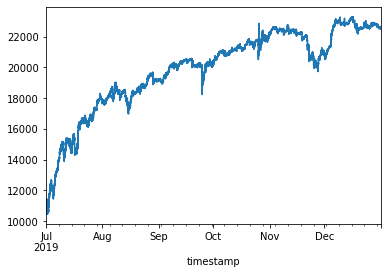

In [14]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

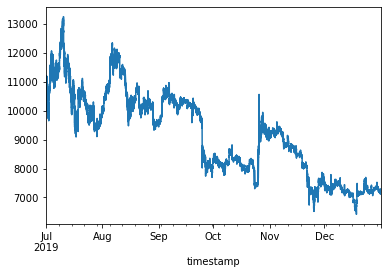

In [15]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

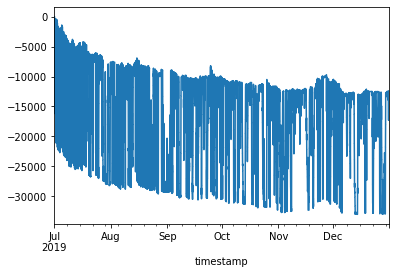

In [16]:
running_qty.plot()

Start date            2019-07-01
End date              2019-12-31
Time period (days)           183
Sharpe Ratio            3.059045
CAGR                    3.373504
Max Daily Drawdown      0.111965
dtype: object


<AxesSubplot:>

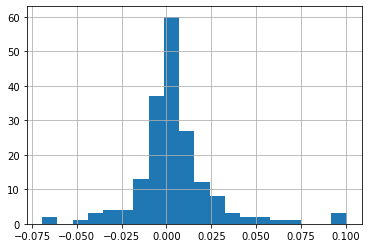

In [17]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

In [18]:
equity, running_qty = search.best_estimator_.predict(valid.values)
equity = pd.Series(equity, index=valid.index)
running_qty = pd.Series(running_qty, index=valid.index)

<AxesSubplot:xlabel='timestamp'>

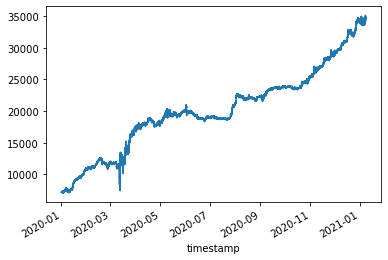

In [19]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

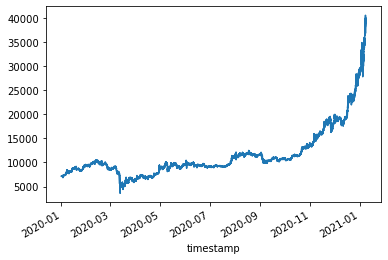

In [20]:
valid["close"].plot()

<AxesSubplot:xlabel='timestamp'>

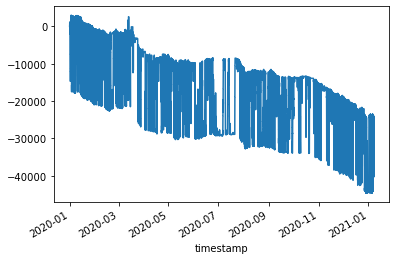

In [21]:
running_qty.plot()

Start date            2020-01-01
End date              2021-01-07
Time period (days)           372
Sharpe Ratio            2.542195
CAGR                    3.703228
Max Daily Drawdown      0.239429
dtype: object


<AxesSubplot:>

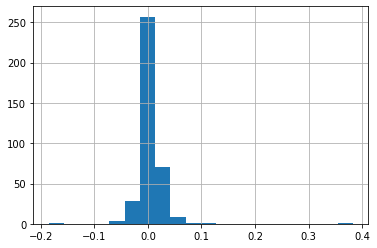

In [22]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

Start date                         2019-04-01
End date                           2021-03-17
Time period (days)                        716
Train period          2019-07-01 - 2019-12-31
Valid period          2020-01-01 - 2021-01-07
Sharpe ratio                         3.410437
CAGR                                 2.931762
RRR                                 23.478288
Maximum drawdown                     0.124871
dtype: object


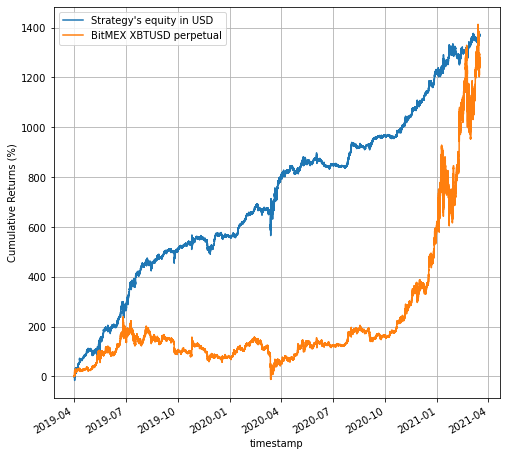

In [23]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'RRR': ((equity[-1] / equity[0]) ** (365 / period) - 1) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = ((equity / equity[0] - 1) * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity in USD", 'BitMEX XBTUSD perpetual'])
ax1.grid()

<AxesSubplot:xlabel='timestamp'>

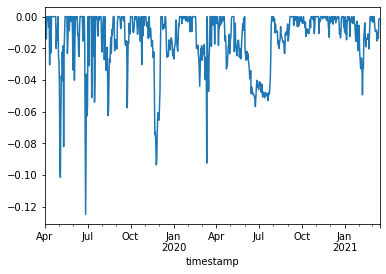

In [24]:
Daily_Drawdown.plot()

<AxesSubplot:xlabel='timestamp'>

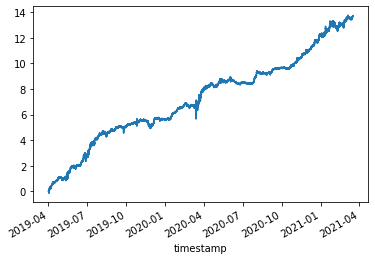

In [25]:
(equity / equity[0] - 1).plot()